# Machine Learning for Equipment Failure Prediction and Equipment Maintenance (PM)

In this notebook, I examine machine failure/predictive maintenance. Predictive Maintenance (PM) is a very common problem in many industries. 

One common issue experienced with PM problems is that machines do not break very often. Think about it.  If a machine breaks all the time, people won't buy it. Modern machines are designed and engineered to last. This means when we try to predict failure, we usually only have a few failures to draw on. In this notebook, we will use a data set that has a failure rate of .14%. In my experience, that is on the high side. The failure rate for most machines is lower than this. In this notebook, I use a few techniques that deal with the small number of failures.

The firm in question provided a sample of data that includes 419 machines that failed over a two year period. On average, when a machine in the sample failed, the firm lost 28,000 dollars. Some of the machines were fixed before they failed, limiting production losses. Others, failed unexpectedly and without warning. 

When there is no warning, the firm scrambled to augment production processes but inevitably lost production and future sales.  If the firm was able to anticipate failure before it occurred, they could minimize the impact on lost production by doing repairs during off hours or shifting production from one machine to another.

Our goal is to develop a predictive model that gives a warning before failure and allows the firm to minimize production losses.

After a preliminary review, it is estimated that fixing a machine before it breaks costs about 1,500 dollars. Fixing a machine that is not broken, costs about 7,500 dollars. A machine that fails unexpectedly and without warning costs the firm 30,000 dollars in repair costs and lost production.  Based on this economics, it is clearly in the firms interest to understand the health of their machines and fix them before they break.


The goal is to build a predictive model that predicts machine failure within nine months of failure. Nine months is reasonable because these particular machines are designed to last at least six years.
Our objective is to develop a solution that will lower the costs of failure. Again, it currently costs the firm about 28,000 per machine. We will attempt to lower this cost.

An important note about the data.  The data is completely fake.  It is data that I created based on my experience of dealing with these types of problems.  Although it is completely fake, I believe the data and use case are very realistic and consistent with many real problems I faced working in PM.



## Table of Contents

1. [Getting Setup](#setup1)<br>
 
2. [Data Exploration](#explore)<br>

3. [Data Transformation and Feature Engineering](#trans)<br>
 
4. [Dealing with the Small Number of Failures](#small)<br>
    4.1 [Expand the Failure Window](#window)<br>
    4.2 [Create Testing, Training and Validation Groups](#groups)<br>
    4.3 [SMOTE the Training Data](#smote)<br>
5. [More Data Transformations and Feature Engineering](#more)<br>
6. [Build the Model on the Balanced Data Set](#build)<br>
7. [Score the Unbalanced Training Data Set](#score)<br>
8. [Business Rules and Heuristics](#bus)<br>
9. [Define a True Positive, True Negative, False Positive and False Negative](#tp)<br>
10. [Apply Model and Heuristics to the Testing and Validation Data Sets](#apply)<br>
11. [Conclusions](#conc)<br>

## 1.0 Getting Set-Up <a id="setup1"></a>

 Install all of the relevant Python Libraries

In [1]:
!pip install --upgrade numpy 
!pip install imblearn --upgrade
!pip install plotly --upgrade
!pip install chart-studio --upgrade

     |████████████████████████████████| 20.2MB 17.6MB/s eta 0:00:01
ERROR: tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.
ERROR: autoai-libs 1.10.5 has requirement pandas>=0.24.2, but you'll have pandas 0.24.1 which is incompatible.
  Found existing installation: numpy 1.15.4
    Uninstalling numpy-1.15.4:
      Successfully uninstalled numpy-1.15.4
     |████████████████████████████████| 163kB 15.9MB/s eta 0:00:01
     |████████████████████████████████| 7.1MB 2.2MB/s eta 0:00:01
     |████████████████████████████████| 296kB 66.3MB/s eta 0:00:01
ERROR: autoai-libs 1.10.5 has requirement pandas>=0.24.2, but you'll have pandas 0.24.1 which is incompatible.
ERROR: autoai-libs 1.10.5 has requirement scikit-learn==0.20.3, but you'll have scikit-learn 0.22.2 which is incompatible.
  Found existing installation: scikit-learn 0.20.3
    Uninstalling scikit-learn-0.20.3:
      Successfully uninstalled scikit-learn-0.20.3
     |████████████████████████████████| 7

Import required libraries

In [2]:
import chart_studio.plotly as py
import plotly.graph_objs as go
import numpy.dual as dual
import plotly as plotly
import pandas as pd
from botocore.client import Config
import ibm_boto3
import numpy as np
import numpy.dual as dual
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from sklearn import metrics

from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0




Using TensorFlow backend.
/opt/conda/envs/Python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/opt/conda/envs/Python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/opt/conda/envs/Python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/opt/conda/envs/Python36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future versi

Import the data from GitHub

In [3]:
#Remove the data if you run this notebook more than once
!rm equipment_failure_data_1.csv

rm: cannot remove ‘equipment_failure_data_1.csv’: No such file or directory


In [4]:
#import first half from github
!wget https://raw.githubusercontent.com/shadgriffin/machine_failure/master/equipment_failure_data_1.csv

--2020-03-02 15:33:20--  https://raw.githubusercontent.com/shadgriffin/machine_failure/master/equipment_failure_data_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13242366 (13M) [text/plain]
Saving to: ‘equipment_failure_data_1.csv’

100%[======================================>] 13,242,366  59.1MB/s   in 0.2s   

2020-03-02 15:33:21 (59.1 MB/s) - ‘equipment_failure_data_1.csv’ saved [13242366/13242366]



In [5]:
# Convert csv to pandas dataframe
pd_data_1 = pd.read_csv("equipment_failure_data_1.csv", sep=",", header=0)

In [6]:
#Remove the data if you run this notebook more than once
!rm equipment_failure_data_2.csv

rm: cannot remove ‘equipment_failure_data_2.csv’: No such file or directory


In [7]:
#Import the second half from github
!wget https://raw.githubusercontent.com/shadgriffin/machine_failure/master/equipment_failure_data_2.csv

--2020-03-02 15:33:23--  https://raw.githubusercontent.com/shadgriffin/machine_failure/master/equipment_failure_data_2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921190 (13M) [text/plain]
Saving to: ‘equipment_failure_data_2.csv’

100%[======================================>] 13,921,190  --.-K/s   in 0.1s    

2020-03-02 15:33:24 (94.3 MB/s) - ‘equipment_failure_data_2.csv’ saved [13921190/13921190]



In [8]:
# convert to pandas dataframe
pd_data_2 = pd.read_csv("equipment_failure_data_2.csv", sep=",", header=0)

In [9]:
#concatenate the two data files into one dataframe
pd_data=pd.concat([pd_data_1, pd_data_2])



## 2.0 Data Exporation <a id="explore"></a>

In [10]:
pd_data.head()

,WELL_ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT
0,100001.0,2014-12-02,G,O,Y,1,11.088000,145.223448,39.34,3501.0,8.426869,1.9,24.610345,0.0,0.0,880.0
1,100001.0,2014-12-03,G,O,Y,1,8.877943,187.573214,39.20,3489.0,6.483714,1.9,24.671429,0.0,0.0,881.0
2,100001.0,2014-12-04,G,O,Y,1,8.676444,148.363704,38.87,3459.0,6.159659,2.0,24.733333,0.0,0.0,882.0
3,100001.0,2014-12-05,G,O,Y,1,9.988338,133.660000,39.47,3513.0,9.320308,2.0,24.773077,0.0,0.0,883.0
4,100001.0,2014-12-06,G,O,Y,1,8.475264,197.181600,40.33,3589.0,8.022960,1.5,24.808000,0.0,0.0,884.0


WELL_ID -- ID field that represents a specific machine.

DATE -- The date of the observation.

REGION_CLUSTER -- a field that represents the region in which the machine is located.

MAINTENANCE_VENDOR -- a field that represents the company that provides maintenance and service to the machine.

MANUFACTURER -- the company that manufactured the equipment in question.

WELL_GROUP -- a field representing the type of Machine.


EQUIPMENT_AGE -- Age of the machine, in days.

S15 -- A Sensor Value.

S17 -- A Sensor Value.

S13 -- A Sensor Value.

S16 -- A Sensor Value.

S19 -- A Sensor Value.

S18 -- A Sensor Value.

S8  -- A Sensor Value.

EQUIPMENT_FAILURE -- A '1' means that the equipment failed.  A '0' means the equipment did not fail.


Our first goal in this exercise is to build a model that predicts equipment failure.  In other words, we will use the other useful variables in the data table to predict EQUIPMENT_FAILURE.

Now we will walk through the data, gaining an understanding of what kind of data set we are dealing with in this example.




Examine the number of rows and columns.  The data has 307,751 rows and 16 columns

In [11]:

pd_data.shape

(307751, 16)

There are 421 machines in the data set

In [12]:

xxxx = pd.DataFrame(pd_data.groupby(['WELL_ID']).agg(['count']))
xxxx.shape

(421, 15)

there are 731 unique dates in the data set

In [13]:

xxxx = pd.DataFrame(pd_data.groupby(['DATE']).agg(['count']))
xxxx.shape

(731, 15)


We have 731 unique dates.  So if we have 421 machines and 731 unique dates, we should have 307,751 total records.  Based on the .shape command a few steps ago, we have one record per machine per date value.  There are no duplicates in the data frame.



And to triple confirm remove all duplicates and count the rows again.

In [14]:
df_failure_thingy=pd_data
df_failure_thingy=df_failure_thingy.drop_duplicates(subset=['WELL_ID','DATE'])
df_failure_thingy.shape


(307751, 16)

Look for null values in the fields -- There are none

In [15]:
pd_data.isnull().sum(axis = 0)

WELL_ID               0
DATE                  0
REGION_CLUSTER        0
MAINTENANCE_VENDOR    0
MANUFACTURER          0
WELL_GROUP            0
S15                   0
S17                   0
S13                   0
S5                    0
S16                   0
S19                   0
S18                   0
EQUIPMENT_FAILURE     0
S8                    0
AGE_OF_EQUIPMENT      0
dtype: int64

Now let's examine the dependent variable in more detail.  It appears that out of 307,751 records, we only have 421 failures.  This corresponds to a failure rate of about .14%.  In other words, for every failure you have over 700 non-failures.  This data set is very unbalanced.

In [16]:
xxxx = pd.DataFrame(pd_data.groupby(['EQUIPMENT_FAILURE'])['WELL_ID'].agg('count'))
xxxx

,WELL_ID
EQUIPMENT_FAILURE,
0.0,307330
1.0,421


We can also explore the data with descriptive statistics

In [17]:

pd_data.describe()

,WELL_ID,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT
count,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000,307751.000000
mean,100310.826603,4.543943,14.585192,80.265541,35.018249,4675.848252,7.972097,9.069123,137.963064,0.001368,144.665715,2524.192399
std,177.574390,2.284121,8.817056,85.804273,14.446585,2521.074632,2.321949,16.898887,238.890128,0.036961,240.773926,3158.930976
min,100001.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-16.490000,0.000000
25%,100161.000000,3.000000,7.694100,0.000000,28.200000,3209.000000,6.621500,0.900000,11.798276,0.000000,9.250000,721.000000
50%,100311.000000,5.000000,11.661600,31.680000,34.940000,4237.047619,8.004000,4.200000,38.200000,0.000000,53.080000,1113.000000
75%,100467.000000,6.000000,22.560000,160.080000,41.610000,5743.000000,9.460000,10.600000,150.900000,0.000000,165.092608,2784.000000
max,100617.000000,8.000000,59.040000,2555.520000,592.890000,52767.000000,24.600000,511.000000,4151.700000,1.000000,2068.110000,15170.000000


Examine a simple correlation of the independent variable with the dependent variable.  

In [18]:
xxx=pd_data.corr( method='pearson')

xxx=xxx[['EQUIPMENT_FAILURE']]
xxx['ABS_EQUIPMENT_FAILURE']=abs(xxx['EQUIPMENT_FAILURE'])
xxx=xxx.sort_values(by=['ABS_EQUIPMENT_FAILURE'], ascending=[False])

In [19]:
xxx

,EQUIPMENT_FAILURE,ABS_EQUIPMENT_FAILURE
EQUIPMENT_FAILURE,1.000000e+00,1.000000e+00
S15,-6.036352e-02,6.036352e-02
S17,-3.429070e-02,3.429070e-02
S18,9.765002e-03,9.765002e-03
S13,-8.617761e-03,8.617761e-03
S5,-7.189979e-03,7.189979e-03
S8,6.517148e-03,6.517148e-03
S16,-6.138895e-03,6.138895e-03
S19,-6.087474e-03,6.087474e-03
AGE_OF_EQUIPMENT,4.733368e-04,4.733368e-04


## 3.0 Data transformations and Feature Engineering <a id="trans"></a>

Convert dates from character to dates

In [20]:


pd_data['DATE'] = pd.to_datetime(pd_data['DATE'])





Create a new field called "flipper" that indicates when a the well_id changes as the data is sorted by WELL_ID and DATE in ascending order.  We will use this in a few other transformations.

In [21]:
pd_data=pd_data.sort_values(by=['WELL_ID','DATE'], ascending=[True, True])

pd_data['flipper'] = np.where((pd_data.WELL_ID != pd_data.WELL_ID.shift(1)), 1, 0)
pd_data.head()

,WELL_ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,S5,S16,S19,S18,EQUIPMENT_FAILURE,S8,AGE_OF_EQUIPMENT,flipper
0,100001.0,2014-12-02,G,O,Y,1,11.088000,145.223448,39.34,3501.0,8.426869,1.9,24.610345,0.0,0.0,880.0,1
1,100001.0,2014-12-03,G,O,Y,1,8.877943,187.573214,39.20,3489.0,6.483714,1.9,24.671429,0.0,0.0,881.0,0
2,100001.0,2014-12-04,G,O,Y,1,8.676444,148.363704,38.87,3459.0,6.159659,2.0,24.733333,0.0,0.0,882.0,0
3,100001.0,2014-12-05,G,O,Y,1,9.988338,133.660000,39.47,3513.0,9.320308,2.0,24.773077,0.0,0.0,883.0,0
4,100001.0,2014-12-06,G,O,Y,1,8.475264,197.181600,40.33,3589.0,8.022960,1.5,24.808000,0.0,0.0,884.0,0


Calculate the number of days since the first day a machine appears to the current day. This field will be called "TIME_SINCE_START"  Also create a variable called "too_soon".  When "too_soon" is equal to 1 we have less than 5 days of history for the machine.

We will use these new variables to create a running mean, median, max and min.  Also, we will need to augment the running statistics for records that have less than five days of history.


In [22]:
dfx=pd_data

In [23]:
#Select the first record of each machine

starter=dfx[dfx['flipper'] == 1]

starter=starter[['DATE','WELL_ID']]

In [24]:
#rename data to start_date
starter=starter.rename(index=str, columns={"DATE": "START_DATE"})

In [25]:
#convert START_DATE to date
starter['START_DATE'] = pd.to_datetime(starter['START_DATE'])

In [26]:
#Merge START_DATE to the original data set

dfx=dfx.sort_values(by=['WELL_ID', 'DATE'], ascending=[True, True])
starter=starter.sort_values(by=['WELL_ID'], ascending=[True])
dfx =dfx.merge(starter, on=['WELL_ID'], how='left')

In [27]:
# calculate the number of days since the beginning of each well. 
dfx['C'] = dfx['DATE'] - dfx['START_DATE']
dfx['TIME_SINCE_START'] = dfx['C'] / np.timedelta64(1, 'D')
dfx=dfx.drop(columns=['C'])
dfx['too_soon'] = np.where((dfx.TIME_SINCE_START <= 4) , 1, 0)


Create a running mean, max, min and median for the sensor variables.


In [28]:
dfx['S5_mean'] = np.where((dfx.too_soon == 0),(dfx['S5'].rolling(min_periods=1, window=5).mean()) , dfx.S5)
dfx['S5_median'] = np.where((dfx.too_soon == 0),(dfx['S5'].rolling(min_periods=1, window=5).median()) , dfx.S5)
dfx['S5_max'] = np.where((dfx.too_soon == 0),(dfx['S5'].rolling(min_periods=1, window=5).max()) , dfx.S5)
dfx['S5_min'] = np.where((dfx.too_soon == 0),(dfx['S5'].rolling(min_periods=1, window=5).min()) , dfx.S5)


dfx['S13_mean'] = np.where((dfx.too_soon == 0),(dfx['S13'].rolling(min_periods=1, window=5).mean()) , dfx.S13)
dfx['S13_median'] = np.where((dfx.too_soon == 0),(dfx['S13'].rolling(min_periods=1, window=5).median()) , dfx.S13)
dfx['S13_max'] = np.where((dfx.too_soon == 0),(dfx['S13'].rolling(min_periods=1, window=5).max()) , dfx.S13)
dfx['S13_min'] = np.where((dfx.too_soon == 0),(dfx['S13'].rolling(min_periods=1, window=5).min()) , dfx.S13)


dfx['S15_mean'] = np.where((dfx.too_soon == 0),(dfx['S15'].rolling(min_periods=1, window=5).mean()) , dfx.S15)
dfx['S15_median'] = np.where((dfx.too_soon == 0),(dfx['S15'].rolling(min_periods=1, window=5).median()) , dfx.S15)
dfx['S15_max'] = np.where((dfx.too_soon == 0),(dfx['S15'].rolling(min_periods=1, window=5).max()) , dfx.S15)
dfx['S15_min'] = np.where((dfx.too_soon == 0),(dfx['S15'].rolling(min_periods=1, window=5).min()) , dfx.S15)

dfx['S16_mean'] = np.where((dfx.too_soon == 0),(dfx['S16'].rolling(min_periods=1, window=5).mean()) , dfx.S16)
dfx['S16_median'] = np.where((dfx.too_soon == 0),(dfx['S16'].rolling(min_periods=1, window=5).median()) , dfx.S16)
dfx['S16_max'] = np.where((dfx.too_soon == 0),(dfx['S16'].rolling(min_periods=1, window=5).max()) , dfx.S16)
dfx['S16_min'] = np.where((dfx.too_soon == 0),(dfx['S16'].rolling(min_periods=1, window=5).min()) , dfx.S16)


dfx['S17_mean'] = np.where((dfx.too_soon == 0),(dfx['S17'].rolling(min_periods=1, window=5).mean()) , dfx.S17)
dfx['S17_median'] = np.where((dfx.too_soon == 0),(dfx['S17'].rolling(min_periods=1, window=5).median()) , dfx.S17)
dfx['S17_max'] = np.where((dfx.too_soon == 0),(dfx['S17'].rolling(min_periods=1, window=5).max()) , dfx.S17)
dfx['S17_min'] = np.where((dfx.too_soon == 0),(dfx['S17'].rolling(min_periods=1, window=5).min()) , dfx.S17)

dfx['S18_mean'] = np.where((dfx.too_soon == 0),(dfx['S18'].rolling(min_periods=1, window=5).mean()) , dfx.S18)
dfx['S18_median'] = np.where((dfx.too_soon == 0),(dfx['S18'].rolling(min_periods=1, window=5).median()) , dfx.S18)
dfx['S18_max'] = np.where((dfx.too_soon == 0),(dfx['S18'].rolling(min_periods=1, window=5).max()) , dfx.S18)
dfx['S18_min'] = np.where((dfx.too_soon == 0),(dfx['S18'].rolling(min_periods=1, window=5).min()) , dfx.S18)



dfx['S19_mean'] = np.where((dfx.too_soon == 0),(dfx['S19'].rolling(min_periods=1, window=5).mean()) , dfx.S19)
dfx['S19_median'] = np.where((dfx.too_soon == 0),(dfx['S19'].rolling(min_periods=1, window=5).median()) , dfx.S19)
dfx['S19_max'] = np.where((dfx.too_soon == 0),(dfx['S19'].rolling(min_periods=1, window=5).max()) , dfx.S19)
dfx['S19_min'] = np.where((dfx.too_soon == 0),(dfx['S19'].rolling(min_periods=1, window=5).min()) , dfx.S19)


dfx.head()

,WELL_ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,S5,...,S17_max,S17_min,S18_mean,S18_median,S18_max,S18_min,S19_mean,S19_median,S19_max,S19_min
0,100001.0,2014-12-02,G,O,Y,1,11.088000,145.223448,39.34,3501.0,...,145.223448,145.223448,24.610345,24.610345,24.610345,24.610345,1.9,1.9,1.9,1.9
1,100001.0,2014-12-03,G,O,Y,1,8.877943,187.573214,39.20,3489.0,...,187.573214,187.573214,24.671429,24.671429,24.671429,24.671429,1.9,1.9,1.9,1.9
2,100001.0,2014-12-04,G,O,Y,1,8.676444,148.363704,38.87,3459.0,...,148.363704,148.363704,24.733333,24.733333,24.733333,24.733333,2.0,2.0,2.0,2.0
3,100001.0,2014-12-05,G,O,Y,1,9.988338,133.660000,39.47,3513.0,...,133.660000,133.660000,24.773077,24.773077,24.773077,24.773077,2.0,2.0,2.0,2.0
4,100001.0,2014-12-06,G,O,Y,1,8.475264,197.181600,40.33,3589.0,...,197.181600,197.181600,24.808000,24.808000,24.808000,24.808000,1.5,1.5,1.5,1.5


 Create a poor man's derivative for each signal.  This is to look for sudden changes in sensor values.

In [29]:
dfx['S5_chg'] = np.where((dfx.S5_mean == 0),0 , dfx.S5/dfx.S5_mean)


dfx['S13_chg'] = np.where((dfx.S13_mean == 0),0 , dfx.S13/dfx.S13_mean)

dfx['S15_chg'] = np.where((dfx.S15_mean==0),0 , dfx.S15/dfx.S15_mean)
dfx['S16_chg'] = np.where((dfx.S16_mean == 0),0 , dfx.S16/dfx.S16_mean)
dfx['S17_chg'] = np.where((dfx.S17_mean == 0),0 , dfx.S17/dfx.S17_mean)
dfx['S18_chg'] = np.where((dfx.S18_mean == 0),0 , dfx.S18/dfx.S18_mean)
dfx['S19_chg'] = np.where((dfx.S19_mean == 0),0 , dfx.S19/dfx.S19_mean)

In [30]:
#copy the data set to the original name
pd_data=dfx

## 4.0 Dealing with the small number of failures. <a id="small"></a>

### 4.1 Expand the Failure Window <a id="window"></a>

One way to increase the number of failures is to expand the failure window.  That is, make the dependent variable not just the day the equipment failed, but the 30 days leading up to the failure.  

Sort the data by WELL_ID and DATE.  Make sure the index reflects this order.

In [31]:
pd_data=pd_data.sort_values(by=['WELL_ID', 'DATE'], ascending=[True, True])
pd_data.reset_index(level=0, inplace=True)

Create a new data frame that contains the failure records.  Rename DATE to FAILURE_DATE

In [32]:


df_failure_thingy=pd_data[pd_data['EQUIPMENT_FAILURE'] == 1]

df_failure_thingy=df_failure_thingy[['DATE','WELL_ID']]

df_failure_thingy=df_failure_thingy.rename(index=str, columns={"DATE": "FAILURE_DATE"})

pd_data=pd_data.sort_values(by=['WELL_ID'], ascending=[True])
df_failure_thingy=df_failure_thingy.sort_values(by=['WELL_ID'], ascending=[True])


Append the FAILURE_DATE to each WELL_ID

In [33]:


pd_data =pd_data.merge(df_failure_thingy, on=['WELL_ID'], how='left')

For each record calculate the number of days until failure.

In [34]:


pd_data=pd_data.sort_values(by=['WELL_ID','DATE'], ascending=[True, True])

pd_data['FAILURE_DATE'] = pd.to_datetime(pd_data['FAILURE_DATE'])
pd_data['DATE'] = pd.to_datetime(pd_data['DATE'])
pd_data['C'] = pd_data['FAILURE_DATE'] - pd_data['DATE']

pd_data['TIME_TO_FAILURE'] = pd_data['C'] / np.timedelta64(1, 'D')

Clean up and sort the records by WELL_ID and DATE

In [35]:
pd_data=pd_data.drop(columns=['index'])

In [36]:
pd_data=pd_data.sort_values(by=['WELL_ID', 'DATE'], ascending=[True, True])



In [37]:
pd_data.reset_index(inplace=True)


In [38]:
pd_data.head()

,index,WELL_ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,...,S5_chg,S13_chg,S15_chg,S16_chg,S17_chg,S18_chg,S19_chg,FAILURE_DATE,C,TIME_TO_FAILURE
0,0,100001.0,2014-12-02,G,O,Y,1,11.088000,145.223448,39.34,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,143 days,143.0
1,549,100001.0,2014-12-03,G,O,Y,1,8.877943,187.573214,39.20,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,142 days,142.0
2,483,100001.0,2014-12-04,G,O,Y,1,8.676444,148.363704,38.87,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,141 days,141.0
3,484,100001.0,2014-12-05,G,O,Y,1,9.988338,133.660000,39.47,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,140 days,140.0
4,485,100001.0,2014-12-06,G,O,Y,1,8.475264,197.181600,40.33,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,139 days,139.0


Create a new variable, FAILURE_TARGET.  It is equal to 1 if the record proceeds a failure by 30 days or less.

In [39]:
pd_data['FAILURE_TARGET'] = np.where(((pd_data.TIME_TO_FAILURE < 30) & ((pd_data.TIME_TO_FAILURE>=0))), 1, 0)

pd_data.head()

,index,WELL_ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,...,S13_chg,S15_chg,S16_chg,S17_chg,S18_chg,S19_chg,FAILURE_DATE,C,TIME_TO_FAILURE,FAILURE_TARGET
0,0,100001.0,2014-12-02,G,O,Y,1,11.088000,145.223448,39.34,...,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,143 days,143.0,0
1,549,100001.0,2014-12-03,G,O,Y,1,8.877943,187.573214,39.20,...,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,142 days,142.0,0
2,483,100001.0,2014-12-04,G,O,Y,1,8.676444,148.363704,38.87,...,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,141 days,141.0,0
3,484,100001.0,2014-12-05,G,O,Y,1,9.988338,133.660000,39.47,...,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,140 days,140.0,0
4,485,100001.0,2014-12-06,G,O,Y,1,8.475264,197.181600,40.33,...,1.0,1.0,1.0,1.0,1.0,1.0,2015-04-24,139 days,139.0,0


A new variable called FAILURE_TARGET represents the thirty days leading up to the failure.

In [40]:
tips_summed = pd_data.groupby(['FAILURE_TARGET'])['S5'].count()
tips_summed

FAILURE_TARGET
0    295187
1     12564
Name: S5, dtype: int64

The new field occurs about 4% of the time.

In [41]:
pd_data['FAILURE_TARGET'].mean()

0.04082521259069832

Now we have 12,564 target observations.  This is better, but the data set is far from balanced. In the next section we will use SMOTE to synthetically increase the number of failures.  Before we do that, however, let's split our data into a training, a testing and a validation sample.

### 4.2 Create the Testing, Training and Validation Groupings <a id="groups"></a>

Because we are dealing with a panel data set (cross-sectional time-series) it is better to not just take a random sample of all records.  Doing so would put the records from one machine in all three sample data sets.  To avoid this, we'll need to randomly select WELL_IDs and place all of the records for each machine in either the training, testing or validation data set.


In [42]:
#Get a Unique List of All WELL_IDs 


aa=pd_data

pd_well_id=aa.drop_duplicates(subset='WELL_ID')
pd_well_id=pd_well_id[['WELL_ID']]
pd_well_id.shape


(421, 1)

Create a new variable with a random number between 0 and 1

In [43]:
np.random.seed(42)

In [44]:
pd_well_id['wookie'] = (np.random.randint(0, 10000, pd_well_id.shape[0]))/10000

In [45]:

pd_well_id=pd_well_id[['WELL_ID', 'wookie']]

Give each record a 30% chance of being in the validation, a 35% chance of being in the testing and a 35% chance of being in the training data set


In [46]:
pd_well_id['MODELING_GROUP'] = np.where(((pd_well_id.wookie <= 0.35)), 'TRAINING', np.where(((pd_well_id.wookie <= 0.65)), 'VALIDATION', 'TESTING'))

This is how many machines fall in each group

In [47]:
tips_summed = pd_well_id.groupby(['MODELING_GROUP'])['wookie'].count()
tips_summed

MODELING_GROUP
TESTING       149
TRAINING      146
VALIDATION    126
Name: wookie, dtype: int64

Append the Group of each id to each individual record

In [48]:
pd_data=pd_data.sort_values(by=['WELL_ID'], ascending=[True])
pd_well_id=pd_well_id.sort_values(by=['WELL_ID'], ascending=[True])

In [49]:
pd_data =pd_data.merge(pd_well_id, on=['WELL_ID'], how='inner')

pd_data.head()

,index,WELL_ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,...,S16_chg,S17_chg,S18_chg,S19_chg,FAILURE_DATE,C,TIME_TO_FAILURE,FAILURE_TARGET,wookie,MODELING_GROUP
0,0,100001.0,2014-12-02,G,O,Y,1,11.088,145.223448,39.34,...,1.000000,1.0,1.000000,1.000000,2015-04-24,143 days,143.0,0,0.727,TESTING
1,1,100001.0,2016-03-29,G,O,Y,1,18.960,0.000000,38.87,...,1.136092,0.0,0.985460,1.000000,2015-04-24,-340 days,-340.0,0,0.727,TESTING
2,2,100001.0,2016-03-30,G,O,Y,1,29.040,0.000000,37.36,...,1.110177,0.0,0.977199,1.060606,2015-04-24,-341 days,-341.0,0,0.727,TESTING
3,3,100001.0,2016-03-31,G,O,Y,1,18.000,0.000000,38.81,...,0.910000,0.0,0.987958,1.044776,2015-04-24,-342 days,-342.0,0,0.727,TESTING
4,4,100001.0,2016-04-01,G,O,Y,1,26.160,0.000000,39.47,...,1.147059,0.0,0.998350,1.029412,2015-04-24,-343 days,-343.0,0,0.727,TESTING


This is how many records are in each group.

In [50]:
tips_summed = pd_data.groupby(['MODELING_GROUP'])['wookie'].count()
tips_summed

MODELING_GROUP
TESTING       108919
TRAINING      106726
VALIDATION     92106
Name: wookie, dtype: int64

This is how many failure targets are in each group.

In [51]:
tips_summed = pd_data.groupby(['MODELING_GROUP'])['FAILURE_TARGET'].sum()
tips_summed

MODELING_GROUP
TESTING       4439
TRAINING      4357
VALIDATION    3768
Name: FAILURE_TARGET, dtype: int64

Create a separate data frame for the training data set and another for all groups together.

In [52]:
df_training=pd_data[pd_data['MODELING_GROUP'] == 'TRAINING']

df_training=df_training.drop(columns=['MODELING_GROUP','C','wookie','TIME_TO_FAILURE','flipper','START_DATE'])
df_training.shape

(106726, 56)

In [53]:
df_total=pd_data.drop(columns=['C','wookie','TIME_TO_FAILURE','flipper','START_DATE'])
df_total.shape

(307751, 57)

### 4.3 SMOTE the Training Data <a id="smote"></a>

 Define the Training features and Target

In [54]:
training_features=df_training[['REGION_CLUSTER','MAINTENANCE_VENDOR','MANUFACTURER','WELL_GROUP','AGE_OF_EQUIPMENT','S15','S17','S13','S5',
 'S16','S19','S18','S8','S5_mean','S5_median','S5_max','S5_min','S13_mean','S13_median','S13_max','S13_min','S15_mean','S15_median',
 'S15_max','S15_min','S16_mean','S16_median','S16_max','S16_min','S17_mean','S17_median','S17_max','S17_min','S18_mean','S18_median','S18_max','S18_min','S19_mean','S19_median','S19_max','S19_min',
 'S5_chg','S13_chg','S15_chg','S16_chg','S17_chg','S18_chg','S19_chg']]

In [55]:
training_target=df_training[['FAILURE_TARGET']]

Synthetically Balance the training data sets with a SMOTE algorithm.  After we apply the SMOTE algorithm, we will have a balanced data set.  50% Failures and 50% Non-Failures. Note that this takes a while to run.

In [56]:
#uncomment these options if you want to expand the number of rows and columns that appear visually on the screen.

#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [57]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
#sm = SMOTE(random_state=12, ratio = 1.0)
smx = SMOTENC(random_state=12,  categorical_features=[0, 1, 2, 3])

In [58]:
x_res, y_res = smx.fit_sample(training_features, training_target.values.ravel())

/opt/conda/envs/Python36/lib/python3.6/site-packages/scipy/sparse/lil.py:512: FutureWarning:

future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.

/opt/conda/envs/Python36/lib/python3.6/site-packages/scipy/sparse/lil.py:514: FutureWarning:

future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.

/opt/conda/envs/Python36/lib/python3.6/site-packages/scipy/sparse/lil.py:518: FutureWarning:

future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.



Convert the SMOTE output back to complete data frames with independent and dependent variables.  Examine the results.

Format the Independent Variables

In [59]:
df_x=pd.DataFrame(x_res)

df_x.columns = [
 'REGION_CLUSTER','MAINTENANCE_VENDOR','MANUFACTURER','WELL_GROUP','AGE_OF_EQUIPMENT','S15','S17','S13','S5','S16','S19',
 'S18','S8','S5_mean','S5_median','S5_max','S5_min','S13_mean','S13_median','S13_max','S13_min','S15_mean','S15_median','S15_max',
 'S15_min','S16_mean','S16_median','S16_max','S16_min','S17_mean','S17_median','S17_max','S17_min','S18_mean','S18_median','S18_max','S18_min',
 'S19_mean','S19_median','S19_max','S19_min','S5_chg','S13_chg','S15_chg','S16_chg','S17_chg','S18_chg','S19_chg']
df_x.head()

,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,AGE_OF_EQUIPMENT,S15,S17,S13,S5,S16,...,S19_median,S19_max,S19_min,S5_chg,S13_chg,S15_chg,S16_chg,S17_chg,S18_chg,S19_chg
0,D,L,R,6,1308.0,15.5184,188.10,36.29,4318.0,8.0073,...,22.4,22.4,22.4,1.000046,1.000165,1.189084,1.031911,1.045872,0.995986,1.000000
1,D,L,R,6,1307.0,10.3032,149.24,36.78,4377.0,7.0766,...,22.4,22.4,22.4,1.009270,1.009275,0.789474,0.875074,0.872269,0.995300,1.000000
2,D,L,R,6,1306.0,11.4480,187.45,35.84,4265.0,8.0259,...,22.4,22.4,22.4,0.979424,0.979449,0.816697,0.953784,1.096763,0.993660,1.000000
3,D,L,R,6,1302.0,15.1368,148.33,37.53,4466.0,8.7163,...,28.9,28.9,22.4,1.018240,1.018232,1.109177,1.051368,1.029955,1.022235,0.851711
4,D,L,R,6,1304.0,14.3736,179.30,36.31,4321.0,7.9396,...,22.4,28.9,22.4,0.983924,0.983904,1.028331,0.912023,1.196498,1.016783,0.945148


Format the Dependent Variable

In [60]:
df_y=pd.DataFrame(y_res)
df_y.columns = ['FAILURE_TARGET']

Check that the dependent variable is balanced.  It is.

In [61]:
df_y.mean(axis = 0) 

FAILURE_TARGET    0.5
dtype: float64

Merge the dependent and independent variables post SMOTE into data frames

In [62]:
df_balanced = pd.concat([df_y, df_x], axis=1)
df_balanced.head()

,FAILURE_TARGET,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,AGE_OF_EQUIPMENT,S15,S17,S13,S5,...,S19_median,S19_max,S19_min,S5_chg,S13_chg,S15_chg,S16_chg,S17_chg,S18_chg,S19_chg
0,0,D,L,R,6,1308.0,15.5184,188.10,36.29,4318.0,...,22.4,22.4,22.4,1.000046,1.000165,1.189084,1.031911,1.045872,0.995986,1.000000
1,0,D,L,R,6,1307.0,10.3032,149.24,36.78,4377.0,...,22.4,22.4,22.4,1.009270,1.009275,0.789474,0.875074,0.872269,0.995300,1.000000
2,0,D,L,R,6,1306.0,11.4480,187.45,35.84,4265.0,...,22.4,22.4,22.4,0.979424,0.979449,0.816697,0.953784,1.096763,0.993660,1.000000
3,0,D,L,R,6,1302.0,15.1368,148.33,37.53,4466.0,...,28.9,28.9,22.4,1.018240,1.018232,1.109177,1.051368,1.029955,1.022235,0.851711
4,0,D,L,R,6,1304.0,14.3736,179.30,36.31,4321.0,...,22.4,28.9,22.4,0.983924,0.983904,1.028331,0.912023,1.196498,1.016783,0.945148


## 5.0 More data transformation and feature engineering <a id="more"></a>

Convert the categorical variables into binary dummy variables. We need to do this because the XGBT model (below) doesn't like categorical fields.

In [63]:
df_dv = pd.get_dummies(df_balanced['REGION_CLUSTER'])

df_dv=df_dv.rename(columns={"A": "CLUSTER_A","B":"CLUSTER_B","C":"CLUSTER_C","D":"CLUSTER_D","E":"CLUSTER_E","F":"CLUSTER_F","G":"CLUSTER_G","H":"CLUSTER_H"})


df_balanced= pd.concat([df_balanced, df_dv], axis=1)


df_dv = pd.get_dummies(df_balanced['MAINTENANCE_VENDOR'])

df_dv=df_dv.rename(columns={"I": "MV_I","J":"MV_J","K":"MV_K","L":"MV_L","M":"MV_M","N":"MV_N","O":"MV_O","P":"MV_P"})


df_balanced = pd.concat([df_balanced, df_dv], axis=1)



df_dv = pd.get_dummies(df_balanced['MANUFACTURER'])

df_dv=df_dv.rename(columns={"Q": "MN_Q","R":"MN_R","S":"MN_S","T":"MN_T","U":"MN_U","V":"MN_V","W":"MN_W","X":"MN_X","Y":"MN_Y","Z":"MN_Z"})


df_balanced = pd.concat([df_balanced, df_dv], axis=1)


df_dv = pd.get_dummies(df_balanced['WELL_GROUP'])

df_dv=df_dv.rename(columns={1: "WG_1",2:"WG_2",3:"WG_3",4:"WG_4",5:"WG_5",6:"WG_6",7:"WG_7",8:"WG_8"})


df_balanced = pd.concat([df_balanced, df_dv], axis=1)


In [64]:
df_dv = pd.get_dummies(df_training['REGION_CLUSTER'])

df_dv=df_dv.rename(columns={"A": "CLUSTER_A","B":"CLUSTER_B","C":"CLUSTER_C","D":"CLUSTER_D","E":"CLUSTER_E","F":"CLUSTER_F","G":"CLUSTER_G","H":"CLUSTER_H"})


df_training= pd.concat([df_training, df_dv], axis=1)


df_dv = pd.get_dummies(df_training['MAINTENANCE_VENDOR'])

df_dv=df_dv.rename(columns={"I": "MV_I","J":"MV_J","K":"MV_K","L":"MV_L","M":"MV_M","N":"MV_N","O":"MV_O","P":"MV_P"})


df_training = pd.concat([df_training, df_dv], axis=1)



df_dv = pd.get_dummies(df_training['MANUFACTURER'])

df_dv=df_dv.rename(columns={"Q": "MN_Q","R":"MN_R","S":"MN_S","T":"MN_T","U":"MN_U","V":"MN_V","W":"MN_W","X":"MN_X","Y":"MN_Y","Z":"MN_Z"})


df_training = pd.concat([df_training, df_dv], axis=1)


df_dv = pd.get_dummies(df_training['WELL_GROUP'])

df_dv=df_dv.rename(columns={1: "WG_1",2:"WG_2",3:"WG_3",4:"WG_4",5:"WG_5",6:"WG_6",7:"WG_7",8:"WG_8"})


df_training = pd.concat([df_training, df_dv], axis=1)



In [65]:
df_dv = pd.get_dummies(df_total['REGION_CLUSTER'])

df_dv=df_dv.rename(columns={"A": "CLUSTER_A","B":"CLUSTER_B","C":"CLUSTER_C","D":"CLUSTER_D","E":"CLUSTER_E","F":"CLUSTER_F","G":"CLUSTER_G","H":"CLUSTER_H"})


df_total= pd.concat([df_total, df_dv], axis=1)


df_dv = pd.get_dummies(df_total['MAINTENANCE_VENDOR'])

df_dv=df_dv.rename(columns={"I": "MV_I","J":"MV_J","K":"MV_K","L":"MV_L","M":"MV_M","N":"MV_N","O":"MV_O","P":"MV_P"})


df_total = pd.concat([df_total, df_dv], axis=1)



df_dv = pd.get_dummies(df_total['MANUFACTURER'])

df_dv=df_dv.rename(columns={"Q": "MN_Q","R":"MN_R","S":"MN_S","T":"MN_T","U":"MN_U","V":"MN_V","W":"MN_W","X":"MN_X","Y":"MN_Y","Z":"MN_Z"})


df_total = pd.concat([df_total, df_dv], axis=1)


df_dv = pd.get_dummies(df_total['WELL_GROUP'])

df_dv=df_dv.rename(columns={1: "WG_1",2:"WG_2",3:"WG_3",4:"WG_4",5:"WG_5",6:"WG_6",7:"WG_7",8:"WG_8"})


df_total = pd.concat([df_total, df_dv], axis=1)

## 6.0 Build the model on the balanced training data set <a id="build"></a>

In [66]:
# Remove the newly redundant categorical variables.  This are now represented by dummy variables.
df_balanced=df_balanced.drop(columns=['REGION_CLUSTER','MAINTENANCE_VENDOR','MANUFACTURER','WELL_GROUP'])

In the balanced data set, Separate the dependent and independent variables to feed to the model development process.

In [67]:

features = [x for x in df_balanced.columns if x not in ['FAILURE_TARGET','EQUIPMENT_FAILURE']]  
dependent=pd.DataFrame(df_balanced['FAILURE_TARGET'])

independent=df_balanced.drop(columns=['FAILURE_TARGET'])

In [68]:
#make sure everything is numeric for simplicity
independent = independent.apply(pd.to_numeric) 
df_balanced = df_balanced.apply(pd.to_numeric)

Define model specs

In [69]:
import matplotlib.pylab as plt
%matplotlib inline

def evaluate_model(alg, train, target, predictors,  early_stopping_rounds=1):
    
   
    #Fit the algorithm on the data
    alg.fit(train[predictors], target['FAILURE_TARGET'], eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(train[predictors])
    dtrain_predprob = alg.predict_proba(train[predictors])[:,1]
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False) 
    feat_imp.plot(kind='bar', title='Feature Importance', color='g') 
    plt.ylabel('Feature Importance Score')
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(target['FAILURE_TARGET'].values, dtrain_predictions))
    print("AUC Score (Balanced): %f" % metrics.roc_auc_score(target['FAILURE_TARGET'], dtrain_predprob))

Initializing our model with default parameters.  Note that we could probably improve the results by tweaking the parameters, but we will save that exercise for another day.  This step can take a while.


Model Report
Accuracy : 0.7945
AUC Score (Balanced): 0.880284


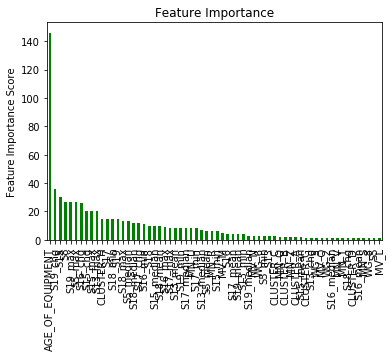

In [70]:
xgb0 = XGBClassifier(
 objective= 'binary:logistic')

evaluate_model(xgb0, independent, dependent,features) 

Using a 50% cut-off on the balanced data, the accuracy is 79.5% and the AUC score is 88%

Now, we will apply the model to the unbalanced training data set.

## 7.0 Score the unbalanced training data set. <a id="score"></a>

In [71]:
df_training['P_FAIL']= xgb0.predict_proba(df_training[features])[:,1];


Use a cut-off of .67 to categorize the p value into a binary variable.

In [72]:
df_training['Y_FAIL'] = np.where(((df_training.P_FAIL <= .67)), 0, 1)


Build a ROC Curve

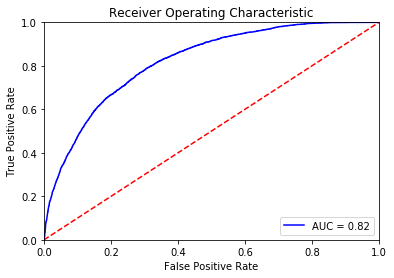

In [73]:
fpr, tpr, threshold=metrics.roc_curve(df_training['FAILURE_TARGET'], df_training['P_FAIL'])
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [74]:

df_training['Y_FAIL'].mean()

0.04399115492007571

With a cut-off of .67 the unblananced training data set has an accuracy of 94% and AUC Score of 82%

In [75]:
#Print model report:
print("Accuracy : %.4g" % metrics.accuracy_score(df_training['FAILURE_TARGET'].values, df_training['Y_FAIL']))
print("AUC Score (Test): %f" % metrics.roc_auc_score(df_training['FAILURE_TARGET'], df_training['P_FAIL']))

Accuracy : 0.9365
AUC Score (Test): 0.820804


Create a confusion Matrix

In [76]:
print(pd.crosstab(df_training.Y_FAIL, df_training.FAILURE_TARGET, dropna=False))
pd.crosstab(df_training.Y_FAIL, df_training.FAILURE_TARGET).apply(lambda r: r/r.sum(), axis=1)

FAILURE_TARGET      0     1
Y_FAIL                     
0               98812  3219
1                3557  1138


FAILURE_TARGET,0,1
Y_FAIL,,
0,0.968451,0.031549
1,0.757614,0.242386


Above is a confusion matrix of a predicted failure against our 30 day lead time failure target.  Let's examine a confusion matrix that details predicted failures with actual failures.

In [77]:
print(pd.crosstab(df_training.Y_FAIL, df_training.EQUIPMENT_FAILURE, dropna=False))
pd.crosstab(df_training.Y_FAIL, df_training.EQUIPMENT_FAILURE).apply(lambda r: r/r.sum(), axis=1)

EQUIPMENT_FAILURE     0.0  1.0
Y_FAIL                        
0                  101964   67
1                    4616   79


EQUIPMENT_FAILURE,0.0,1.0
Y_FAIL,,
0,0.999343,0.000657
1,0.983174,0.016826


Neither of the confusion matrices above represent reality. 

Think about it. In the confusion matrix above, a true positive only occurs if a failure occurs on the same day as the signal. What if a signal happens on Monday and it failed on Tuesday? I would count that as a true positive, but the confusion matrix above does not.

So, we have some cleaning up to do. In the next section, we will build a confusion matrix that is more realistic.




## 8.0 Business Rules and Heuristics <a id="bus"></a>

First, we will create a business rule that eliminates signals in “bunches”.  For example, if there is a signal on Monday, Tuesday and Wednesday, you likely don't have three separate problems.  You more than likely have one problem that was flagged on three consecutive days.  

To reduce the repetitive signals, we will create a business rule.   This business rule will prohibit more than one signal every 120 days.  In a sense, we previously expanded the failure window.  Now, we are collapsing it.



In [78]:
#sort the data by well_id and date.
xx=df_training
xx=xx.sort_values(by=['WELL_ID','DATE'], ascending=[True, True])

In [79]:
# sum of the number of predicted failures over the last 120 days.  If there are less than 120 days, vary the sum to reflect the truncated number of days in history.


xx['Y_FAIL_sumx'] =np.where(xx.TIME_SINCE_START==1, (xx['Y_FAIL'].rolling(min_periods=1, window=1).sum()),
                            np.where(xx.TIME_SINCE_START==2, (xx['Y_FAIL'].rolling(min_periods=1, window=2).sum()),
                            np.where(xx.TIME_SINCE_START==3, (xx['Y_FAIL'].rolling(min_periods=1, window=3).sum()),
                            np.where(xx.TIME_SINCE_START==4, (xx['Y_FAIL'].rolling(min_periods=1, window=4).sum()),
                            np.where(xx.TIME_SINCE_START==5, (xx['Y_FAIL'].rolling(min_periods=1, window=5).sum()),
                            np.where(xx.TIME_SINCE_START==6, (xx['Y_FAIL'].rolling(min_periods=1, window=6).sum()),
                            np.where(xx.TIME_SINCE_START==7, (xx['Y_FAIL'].rolling(min_periods=1, window=7).sum()),
                            np.where(xx.TIME_SINCE_START==8, (xx['Y_FAIL'].rolling(min_periods=1, window=8).sum()),
                            np.where(xx.TIME_SINCE_START==9, (xx['Y_FAIL'].rolling(min_periods=1, window=9).sum()),
                            np.where((xx.TIME_SINCE_START>=10) & (xx.TIME_SINCE_START<=20), (xx['Y_FAIL'].rolling(min_periods=1, window=10).sum()),
                            np.where((xx.TIME_SINCE_START>20) & (xx.TIME_SINCE_START<=30), (xx['Y_FAIL'].rolling(min_periods=1, window=20).sum()),
                            np.where((xx.TIME_SINCE_START>30) & (xx.TIME_SINCE_START<=40), (xx['Y_FAIL'].rolling(min_periods=1, window=30).sum()),
                            np.where((xx.TIME_SINCE_START>40) & (xx.TIME_SINCE_START<=50), (xx['Y_FAIL'].rolling(min_periods=1, window=40).sum()),
                            np.where((xx.TIME_SINCE_START>50) & (xx.TIME_SINCE_START<=60), (xx['Y_FAIL'].rolling(min_periods=1, window=50).sum()),
                            np.where((xx.TIME_SINCE_START>60) & (xx.TIME_SINCE_START<=70), (xx['Y_FAIL'].rolling(min_periods=1, window=60).sum()),
                            np.where((xx.TIME_SINCE_START>70) & (xx.TIME_SINCE_START<=80), (xx['Y_FAIL'].rolling(min_periods=1, window=70).sum()),
                            np.where((xx.TIME_SINCE_START>80) & (xx.TIME_SINCE_START<=90), (xx['Y_FAIL'].rolling(min_periods=1, window=80).sum()),
                            np.where((xx.TIME_SINCE_START>90) & (xx.TIME_SINCE_START<=100), (xx['Y_FAIL'].rolling(min_periods=1, window=90).sum()),
                            np.where((xx.TIME_SINCE_START>100) & (xx.TIME_SINCE_START<=110), (xx['Y_FAIL'].rolling(min_periods=1, window=100).sum()),
                            np.where((xx.TIME_SINCE_START>110) & (xx.TIME_SINCE_START<=120), (xx['Y_FAIL'].rolling(min_periods=1, window=110).sum()),
                            np.where((xx.TIME_SINCE_START==0), 0,
                            np.where((xx.TIME_SINCE_START>=120), (xx['Y_FAIL'].rolling(min_periods=1, window=120).sum()),999))))))))))))))))))))))

In [80]:
#run a frequency to check the logic in the previous step
xxxx = pd.DataFrame(xx.groupby(['Y_FAIL_sumx'])['Y_FAIL'].agg('count'))
xxxx

,Y_FAIL
Y_FAIL_sumx,
0.0,61523
1.0,10965
2.0,5720
3.0,3784
4.0,3093
5.0,2167
6.0,1764
7.0,1411
8.0,1195


In [81]:
#make sure you have no records coded with 999
hhh=xx[xx['Y_FAIL_sumx'] == 999]
hhh

,index,WELL_ID,DATE,REGION_CLUSTER,MAINTENANCE_VENDOR,MANUFACTURER,WELL_GROUP,S15,S17,S13,...,WG_2,WG_3,WG_4,WG_5,WG_6,WG_7,WG_8,P_FAIL,Y_FAIL,Y_FAIL_sumx


In [82]:
# if a signal has occured in the last 120 days, the signal is 0.
xx['Y_FAILZ']=np.where((xx.Y_FAIL_sumx>1), 0, xx.Y_FAIL)

Note that by applying this business rule the number of signals decreases dramatically.

In [83]:
print(pd.crosstab(xx.Y_FAILZ, xx.EQUIPMENT_FAILURE, dropna=False))

EQUIPMENT_FAILURE     0.0  1.0
Y_FAILZ                       
0                  106355  142
1                     225    4


Next we will create a couple of new fields.  The first is a unique id for each signal (SIGNAL_ID).  

In [84]:
#sort the data by well_id and date.

xx=xx.sort_values(by=['WELL_ID','DATE'], ascending=[True, True])

xx['bootie']=1

In [85]:
#create signal id with the cumsum function.
xx['SIGNAL_ID'] = xx['Y_FAILZ'].cumsum()




Now we will pull the records with a signal into a separate data frame.
Here we will create a new field that identifies the date of each signal (SIGNAL_DATE).
Also, we will identify the WELL_ID Associated with each signal (ID_OF_SIGNAL)


In [86]:


df_signals=xx[xx['Y_FAILZ'] == 1]
df_signal_date=df_signals[['SIGNAL_ID','DATE','WELL_ID']]
df_signal_date=df_signal_date.rename(index=str, columns={"DATE": "SIGNAL_DATE"})
df_signal_date=df_signal_date.rename(index=str, columns={"WELL_ID": "ID_OF_SIGNAL"})




We have a total of 229 signals.  Now each has a unique id.  Note that is still too many.  Below we will apply more heuristics to decrease the number of signals.

In [87]:
df_signal_date.shape

(229, 3)

Append the new fields to the working data frame.

In [88]:
xx =xx.merge(df_signal_date, on=['SIGNAL_ID'], how='outer')


Keep the fields we need to use going forward.

In [89]:
xx=xx[['DATE', 'WELL_ID', 'EQUIPMENT_FAILURE', 'FAILURE_TARGET','FAILURE_DATE',
       'P_FAIL', 'Y_FAILZ','SIGNAL_ID',
       'SIGNAL_DATE','ID_OF_SIGNAL']]




 Create a field called "Warning" that indicates the time from signal to failure.

In [90]:

xx['C'] = xx['FAILURE_DATE'] - xx['SIGNAL_DATE']
xx['WARNING'] = xx['C'] / np.timedelta64(1, 'D')


In [91]:
#Replace nan with 9999.  

xx['WARNING'].fillna(9999, inplace=True)

##  9.0 Define a True Positive, True Negative, False Positive and False Negative <a id="tp"></a>


A true positive occurs if and only if the machine fails and there was a signal within the last 270 days (nine months).   Also, we have to ensure that the signal id belongs to the Well ID.  Note that this prohibits a signal from another machine being applied to the machine in question.


A false negative occurs if and only if the machine fails and it is not a true positive.



A False Positive occurs if there is a failure signal and a failure does not  occur in the next 270 days.  Also, if a signal occurs after the failure, this is a false positive.  We also have to ensure that the signal id belongs to the Well ID.    Note that this prohibits a signal from another machine being applied to the machine in question.

If an observation is not a False Positive, a False Negative or a True Positive it is a True Negative.


In [92]:
# define a true positive
xx['TRUE_POSITIVE'] = np.where(((xx.EQUIPMENT_FAILURE == 1) & (xx.WARNING<=270) &(xx.WARNING>=0) & (xx.ID_OF_SIGNAL==xx.WELL_ID)), 1, 0)

In [93]:
# define a false negative
xx['FALSE_NEGATIVE'] = np.where((xx.TRUE_POSITIVE==0) & (xx.EQUIPMENT_FAILURE==1), 1, 0)

In [94]:
# define a false positive
xx['BAD_S']=np.where((xx.WARNING<0) | (xx.WARNING>=270), 1, 0)

xx['FALSE_POSITIVE'] = np.where(((xx.Y_FAILZ == 1) & (xx.BAD_S==1) & (xx.ID_OF_SIGNAL==xx.WELL_ID)), 1, 0)

In [95]:
xx['bootie']=1

In [96]:
xx['MODELING_GROUP']='TRAINING'

Create the final Cross-Tab

In [97]:
xx['CATEGORY']=np.where((xx.FALSE_POSITIVE==1),'FALSE_POSITIVE',
                                      (np.where((xx.FALSE_NEGATIVE==1),'FALSE_NEGATIVE',
                                                (np.where((xx.TRUE_POSITIVE==1),'TRUE_POSITIVE','TRUE_NEGATIVE')))))

In [98]:
table = pd.pivot_table(xx, values=['bootie'], index=['MODELING_GROUP'],columns=['CATEGORY'], aggfunc=np.sum)
table

bootie                                           
CATEGORY       FALSE_NEGATIVE FALSE_POSITIVE TRUE_NEGATIVE TRUE_POSITIVE
MODELING_GROUP                                                          
TRAINING                   22             94        106486           124

Using the previously described definitions of a false positive, false negative, true positive and true negative in the training data set there are:
    
    22 False Negatives
    94 False Positives
    106,486 True Negatives and
    124 True Postives.
    


## 10.0 Apply Model and Heuristics the Testing and Validation Data Sets. <a id="apply"></a>

Predict the probability of failure for all records.

In [99]:
df_total['P_FAIL']= xgb0.predict_proba(df_total[features])[:,1];

Create a predicted failure indicator based on a cut-off of .67.

In [100]:
df_total['Y_FAIL'] = np.where(((df_total.P_FAIL <= .67)), 0, 1)

In [101]:
yy=df_total




In [102]:
yy=yy.sort_values(by=['WELL_ID','DATE'], ascending=[True, True])

Ensure that failure indicator occurs only once every 120 days.

In [103]:

# sum of the number of predicted failures over the last 120 days.  If there are less than 120 days, vary the sum to reflect the truncated number of days in history.


yy['Y_FAIL_sumx'] =np.where(yy.TIME_SINCE_START==1, (yy['Y_FAIL'].rolling(min_periods=1, window=1).sum()),
                            np.where(yy.TIME_SINCE_START==2, (yy['Y_FAIL'].rolling(min_periods=1, window=2).sum()),
                            np.where(yy.TIME_SINCE_START==3, (yy['Y_FAIL'].rolling(min_periods=1, window=3).sum()),
                            np.where(yy.TIME_SINCE_START==4, (yy['Y_FAIL'].rolling(min_periods=1, window=4).sum()),
                            np.where(yy.TIME_SINCE_START==5, (yy['Y_FAIL'].rolling(min_periods=1, window=5).sum()),
                            np.where(yy.TIME_SINCE_START==6, (yy['Y_FAIL'].rolling(min_periods=1, window=6).sum()),
                            np.where(yy.TIME_SINCE_START==7, (yy['Y_FAIL'].rolling(min_periods=1, window=7).sum()),
                            np.where(yy.TIME_SINCE_START==8, (yy['Y_FAIL'].rolling(min_periods=1, window=8).sum()),
                            np.where(yy.TIME_SINCE_START==9, (yy['Y_FAIL'].rolling(min_periods=1, window=9).sum()),
                            np.where((yy.TIME_SINCE_START>=10) & (yy.TIME_SINCE_START<=20), (yy['Y_FAIL'].rolling(min_periods=1, window=10).sum()),
                            np.where((yy.TIME_SINCE_START>20) & (yy.TIME_SINCE_START<=30), (yy['Y_FAIL'].rolling(min_periods=1, window=20).sum()),
                            np.where((yy.TIME_SINCE_START>30) & (yy.TIME_SINCE_START<=40), (yy['Y_FAIL'].rolling(min_periods=1, window=30).sum()),
                            np.where((yy.TIME_SINCE_START>40) & (yy.TIME_SINCE_START<=50), (yy['Y_FAIL'].rolling(min_periods=1, window=40).sum()),
                            np.where((yy.TIME_SINCE_START>50) & (yy.TIME_SINCE_START<=60), (yy['Y_FAIL'].rolling(min_periods=1, window=50).sum()),
                            np.where((yy.TIME_SINCE_START>60) & (yy.TIME_SINCE_START<=70), (yy['Y_FAIL'].rolling(min_periods=1, window=60).sum()),
                            np.where((yy.TIME_SINCE_START>70) & (yy.TIME_SINCE_START<=80), (yy['Y_FAIL'].rolling(min_periods=1, window=70).sum()),
                            np.where((yy.TIME_SINCE_START>80) & (yy.TIME_SINCE_START<=90), (yy['Y_FAIL'].rolling(min_periods=1, window=80).sum()),
                            np.where((yy.TIME_SINCE_START>90) & (yy.TIME_SINCE_START<=100), (yy['Y_FAIL'].rolling(min_periods=1, window=90).sum()),
                            np.where((yy.TIME_SINCE_START>100) & (yy.TIME_SINCE_START<=110), (yy['Y_FAIL'].rolling(min_periods=1, window=100).sum()),
                            np.where((yy.TIME_SINCE_START>110) & (yy.TIME_SINCE_START<=120), (yy['Y_FAIL'].rolling(min_periods=1, window=110).sum()),
                            np.where((yy.TIME_SINCE_START==0), 0,
                            np.where((yy.TIME_SINCE_START>=120), (yy['Y_FAIL'].rolling(min_periods=1, window=120).sum()),999))))))))))))))))))))))

In [104]:
yy['Y_FAILZ']=np.where((yy.Y_FAIL_sumx>1), 0, yy.Y_FAIL)

Create the WARNING Field

In [105]:
yy['bootie']=1

In [106]:
yy=yy.sort_values(by=['WELL_ID','DATE'], ascending=[True, True])

In [107]:
#create a signal id
yy['SIGNAL_ID'] = yy['Y_FAILZ'].cumsum()



In [108]:
#create the signal date and ID_OF_SIGNAL

yy_signals=yy[yy['Y_FAILZ'] == 1]
yy_signal_date=yy_signals[['SIGNAL_ID','DATE','WELL_ID']]
yy_signal_date=yy_signal_date.rename(index=str, columns={"DATE": "SIGNAL_DATE"})
yy_signal_date=yy_signal_date.rename(index=str, columns={"WELL_ID": "ID_OF_SIGNAL"})

In [109]:
#merge the two data frames back into one.

yy =yy.merge(yy_signal_date, on=['SIGNAL_ID'], how='outer')


In [110]:
#Keep on the fields we need
yy=yy[['DATE', 'WELL_ID', 'EQUIPMENT_FAILURE', 'FAILURE_TARGET','FAILURE_DATE','MODELING_GROUP',
       'P_FAIL', 'Y_FAILZ','SIGNAL_ID',
       'SIGNAL_DATE','ID_OF_SIGNAL']]

In [111]:
# Calculate the warning time between each failure date and signal date.
yy['C'] = yy['FAILURE_DATE'] - yy['SIGNAL_DATE']
yy['WARNING'] = yy['C'] / np.timedelta64(1, 'D')

Define True Positives, True Negatives, False Positives and False Negatives.

In [112]:
yy['WARNING'].fillna(9999, inplace=True)


In [113]:
# define a true positive
yy['TRUE_POSITIVE'] = np.where(((yy.EQUIPMENT_FAILURE == 1) & (yy.WARNING<=270) &(yy.WARNING>=0) & (yy.ID_OF_SIGNAL==yy.WELL_ID)), 1, 0)

In [114]:
# define a false negative
yy['FALSE_NEGATIVE'] = np.where((yy.TRUE_POSITIVE==0) & (yy.EQUIPMENT_FAILURE==1), 1, 0)

In [115]:
# define a false positive
yy['BAD_S']=np.where((yy.WARNING<0) | (yy.WARNING>=270), 1, 0)

yy['FALSE_POSITIVE'] = np.where(((yy.Y_FAILZ == 1) & (yy.BAD_S==1) & (yy.ID_OF_SIGNAL==yy.WELL_ID)), 1, 0)

In [116]:
yy['bootie']=1

In [117]:
yy['CATEGORY']=np.where((yy.FALSE_POSITIVE==1),'FALSE_POSITIVE',
                                      (np.where((yy.FALSE_NEGATIVE==1),'FALSE_NEGATIVE',
                                                (np.where((yy.TRUE_POSITIVE==1),'TRUE_POSITIVE','TRUE_NEGATIVE')))))

Define metrics for the Testing, Training and Validation Data sets.

In [118]:
table = pd.pivot_table(yy, values=['bootie'], index=['MODELING_GROUP'],columns=['CATEGORY'], aggfunc=np.sum)
table

bootie                                           
CATEGORY       FALSE_NEGATIVE FALSE_POSITIVE TRUE_NEGATIVE TRUE_POSITIVE
MODELING_GROUP                                                          
TESTING                    64            132        108638            85
TRAINING                   22             94        106486           124
VALIDATION                 53            111         91869            73

Calculate the total cost associated with each false positive, false negative and true positive.  Note that there is no cost with a true negative because no action is taken.

In [119]:
yy['TOTAL_COST']=yy.FALSE_NEGATIVE*30000+yy.FALSE_POSITIVE*7500+yy.TRUE_POSITIVE*1500

Aggregate the costs by modeling group

In [120]:

table = pd.pivot_table(yy, values=['TOTAL_COST'],index=['MODELING_GROUP'], aggfunc=np.sum)
table

,TOTAL_COST
MODELING_GROUP,
TESTING,3037500
TRAINING,1551000
VALIDATION,2532000


Calculate the number of machines per modelling group

In [121]:
wells=yy[['WELL_ID','MODELING_GROUP']]

In [122]:
wells=wells.drop_duplicates(subset='WELL_ID')

wells.shape

(421, 2)

In [123]:
wells = wells.groupby(['MODELING_GROUP'])['WELL_ID'].count()
wells=pd.DataFrame(wells)

Merge the total costs and total machines into one dataframe

In [124]:
tc = yy.groupby(['MODELING_GROUP'])['TOTAL_COST'].sum()
tc=pd.DataFrame(tc)


Calculate the average cost per machine

In [125]:
ac =tc.merge(wells, on=['MODELING_GROUP'], how='inner')


In [126]:
ac['AVERAGE_COST']=ac.TOTAL_COST/ac.WELL_ID

In [127]:
ac

,TOTAL_COST,WELL_ID,AVERAGE_COST
MODELING_GROUP,,,
TESTING,3037500,149,20385.906040
TRAINING,1551000,146,10623.287671
VALIDATION,2532000,126,20095.238095


##  11.0 Conclusions <a id="conc"></a>

It currently costs the firm about 28,000 dollars per machine in the current data set.  By deploying a PM solution, we can lower those costs to between 20,000 and 21,000 dollars.  This equates to a savings of about 7,000 per machine.  For all 419 machine, this is a total savings of about 2,900,000 dollars. 



Not too shabby.


One final note.  There are obviously many judgments I made that work for this example, but may not work for you.  Unfortunately, there is no "one size fits all" solution for any data science problem.   


Nonetheless, this exercise should give you a good reference as you approach these types of problems in the future. 

As far as next steps, I would encourage you to see if you can improve the solution by optimizing the model.  Maybe incorporate some hyper-parameter optimization or even try a different model.  Let me know how it turns out!




### Author





**Shad Griffin**, is a Data Scientist at the IBM Global Solution Center in Dallas, Texas

<hr>
Copyright &copy; IBM Corp. 2020. This notebook and its source code are released under the terms of the MIT License.

